In [1]:
import pyxdf
import mne
import numpy as np
import pandas as pd
import random

In [2]:
# สร้าง list เพื่อเก็บ index ของ epoch ที่ต้องการลบ event_id ออก
def count_each_class(mne_epochs, num_class):
    indices_to_drop = []
    num_class = num_class

    # Iterate ผ่านทุกๆ epoch
    for idx, epoch in enumerate(mne_epochs):
        # ตรวจสอบว่า event_id เป็น {'natural': 0} หรือไม่
        if mne_epochs.events[idx, -1] == num_class:  # ตรวจสอบ event_id ในข้อมูล events ของ epoch นั้นๆ
            # เพิ่ม index ของ epoch ที่ต้องการลบออกใน list
            indices_to_drop.append(idx)

    # ลบ epoch ที่มี event_id เป็น {'natural': 0} ออกจาก mne_epochs
    return indices_to_drop
    # mne_epochs.drop(indices_to_drop)

In [3]:
streams, header = pyxdf.load_xdf("C:/Users/Toey/Desktop/data_ssvep/Toey/exp1/block_1.xdf")
# streams, header = pyxdf.load_xdf("C:/Users/Toey/Downloads/single flicker SSVEP BCI raw data/3.raw_data/1.training_data/sub_1_1.xdf")

In [4]:
raw_data = streams[0]["time_series"].T #From Steam variable this query is EEG data
event_index = streams[1]["time_series"].T[0] #Get all event marker of experiment 

In [125]:
raw_data.shape

(8, 331950)

In [5]:
raw_data = streams[0]["time_series"].T #From Steam variable this query is EEG data
event_index = streams[1]["time_series"].T[0] #Get all event marker of experiment 
#.T คือ transpose array [0] data ใน column 0 ของ streams[1]["time_series"]
event_timestamp = streams[1]["time_stamps"].T #Timestamp when event marked
channels =['Fz','Cz','P4','Pz','P3','P08','Oz','P07'] #Set your target EEG channel name
info = mne.create_info(
    ch_names= channels,
    ch_types= ['eeg']*len(channels),
    sfreq= 250 #OpenBCI Frequency acquistion
)
# Create MNE rawarray
raw_mne = mne.io.RawArray(raw_data, info, verbose=False)
events = np.column_stack((np.array(event_timestamp, dtype = int),
                        np.zeros(len(event_timestamp), dtype = int),
                        np.array(event_index, dtype = int)))
fre1 = 8
fre2 = 10
fre3 = 12
fre4 = 14
events_id = { # Set up your event name
     f'natural': 0,
     f'Frequency {fre1} Hz': 1,
     f'Frequency {fre2} Hz': 2,
     f'Frequency {fre3} Hz': 3,
     f'Frequency {fre4} Hz': 4,
}
mne_epochs = mne.Epochs(raw_mne, events, 
        tmin= -0.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 20,    # final timestamp (10 means set epoch duration 10 second)
        event_id =events_id,
        preload = True,
        event_repeated='drop',
        baseline=(-0.5, 0)
    )
mne_epochs

Not setting metadata
100 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 100 events and 5126 original time points ...
0 bad epochs dropped


Number of events,100
Events,Frequency 10 Hz: 11Frequency 12 Hz: 11Frequency 14 Hz: 11Frequency 8 Hz: 11natural: 56
Time range,-0.500 – 20.000 s
Baseline,-0.500 – 0.000 s


In [46]:
class2 = count_each_class(mne_epochs, 2)

In [47]:
print(class2)

[2, 11, 20, 29, 38, 47, 56, 65, 74, 83, 92]


In [101]:
# ข้อมูลที่สามารถนำไปใช้ได้
class2 = count_each_class(mne_epochs, 2)
x = mne_epochs.get_data()
y = mne_epochs.events[:, -1]
print(x[class2].shape)

(11, 8, 5126)


C:\Users\Toey\AppData\Local\Temp\ipykernel_1268\1517816918.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x = mne_epochs.get_data()


In [102]:
from scipy.signal import butter, lfilter, welch, filtfilt
# Create a function to design a filter (function output b, a = filter coefficients)
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs # define nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


In [105]:
fs = 250
lowcut = 4
highcut = 20
order = 4
data = x[class2]
b, a = butter_bandpass(lowcut, highcut, fs, order)

filtered_data = filtfilt(b,a, data)
print(filtered_data.shape)


(11, 8, 5126)


In [107]:
filtered_data = filtered_data[7, :, :]


In [108]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.signal import welch

5126


(6.0, 15.0)

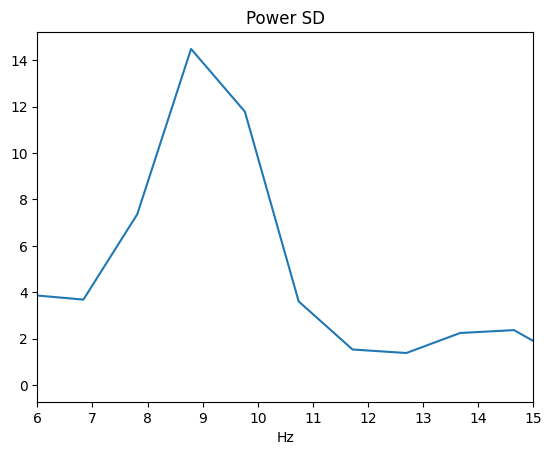

In [122]:
fs = 250
t = np.arange(0, 20, 1/fs)
# data = np.mean(np.mean(filtered_data, 0), 0)
data = np.mean(filtered_data, 0)

print(len(data))

f, Pxx = welch(data[2000:4000], fs)

plt.figure()
# plt.semilogy(f, Pxx)
plt.plot(f, Pxx)
plt.title('Power SD')
plt.xlabel('Hz')
plt.xlim([6,15])

5126


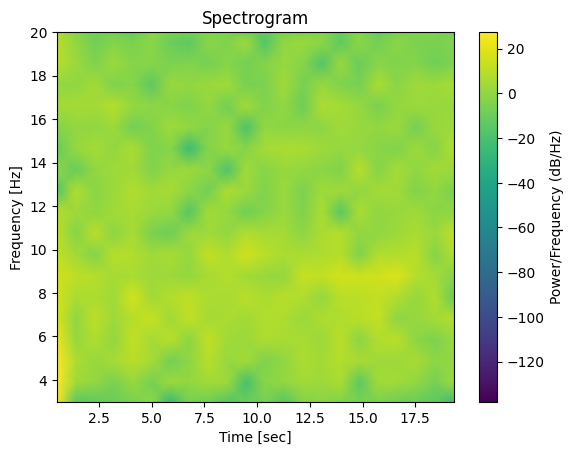

In [123]:
from scipy.signal import spectrogram

# Compute the spectrogram
start = int(5 * 250)
end = int(10 * 250)
print(len(data))
xlim_dat = data
f_spectrogram, t_spectrogram, Sxx = spectrogram(xlim_dat, fs)

# Plot the spectrogram
plt.figure()
plt.pcolormesh(t_spectrogram, f_spectrogram, 10 * np.log10(Sxx), shading='gouraud')
plt.title('Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.ylim([3, 20])  # Limit the y-axis to 50 Hz for better visualization
plt.show()